In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv


## Import Libraries 

In [2]:
path = '../input/spam-mails-dataset/spam_ham_dataset.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
# drop salah satu kolom label
df = df.drop(['label_num'], axis=1)
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


## Exploratory Data Analysis

In [6]:
# cek jumlah keseluruahan baris data
print('Terdapat %s data email'% len(df))

Terdapat 5171 data email


In [7]:
# cek jumlah masing masing label (spam dan ham)
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [8]:
# mengubah label "ham" menjadi "non-spam" agar lebih mudah dipahami
df['label'] = df['label'].replace(['ham'],'non-spam')

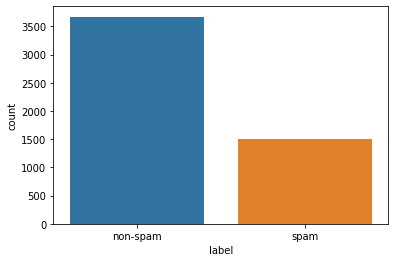

In [9]:
# plot persebaran jumlah masing masing label ke dalam bar chart
df_label = sns.countplot(df['label'])
df_label.set_xticklabels(df['label'].unique())
plt.show()

**Dapat dilihat bahwa persebaran data _spam_ dan _non-spam_ tidak seimbang, oleh karena pada tahap PREPROCESSING perlu disamakan jumlah data kedua label tersebut.**

**Melihat sample text**

In [10]:
print(df['text'][0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


# Preprocessing

karena data label tidak seimbang maka hanya diambil 1000 data pada masing masing label.

In [11]:
df = df.groupby('label').head(1000)

In [12]:
df['label'].value_counts()

non-spam    1000
spam        1000
Name: label, dtype: int64

## Text Cleaning

In [13]:
import string

punct = []
for char in string.punctuation:
    punct.append(char)

In [14]:
def cleaning(txt):
    # case folding
    text = txt.lower()
    
    # remove multiple space, tabs, dan newlines
    text = re.sub('\s+',' ',text)
    
    # remove links
    text = text.replace("http://", " ").replace("https://", " ")
    
    # remove special characters
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    
    # remove punctuation
    text = ''.join([word for word in text if word not in punct])
    
    #remove single character
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    
    #remove numbers
    text = re.sub(r"\d+", "", text)
    
    #remove multiple spaces (again)
    text = re.sub('\s+',' ',text)
    
    return text

In [15]:
# apply fungsi cleaning ke setiap text
df['text_cleaned'] = df['text'].apply(lambda x: cleaning(x))
df = df[['text', 'text_cleaned', 'label']]
df.head()

,text,text_cleaned,label
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter this is follow up...,non-spam
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom for january see attached file ...,non-spam
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho we re around to ...,non-spam
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...,spam
4,Subject: re : indian springs\r\nthis deal is t...,subject re indian springs this deal is to book...,non-spam


## Stopword Removal

In [16]:
stop = stopwords.words('english')
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

## Lemmatization

In [17]:
lemmatizer = WordNetLemmatizer()

# mapping the POS tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)   

def do_lemma(string):
    lemmatized = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(string)])
    return lemmatized

In [18]:
sentence = "The striped bats are hanging on their feet for best"
lemmatized = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sentence)])
print(do_lemma(sentence))

The strip bat be hang on their foot for best


In [19]:
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: do_lemma(x))

In [20]:
df.head()

,text,text_cleaned,label
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter follow note give ...,non-spam
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom january see attach file hplnol...,non-spam
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho around wonderful...,non-spam
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop window office cheap main tre...,spam
4,Subject: re : indian springs\r\nthis deal is t...,subject indian spring deal book teco pvr reven...,non-spam


# Data Preparation

In [21]:
df = df.drop(['text'], axis=1)
df = df.rename(columns = {'text_cleaned' : 'text'})
df.columns

Index(['text', 'label'], dtype='object')

# Feature Extraction using TF-IDF

In [22]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['text'])
y = df['label']

## train test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Model

### Naive Bayes

In [24]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)

MultinomialNB()

In [25]:
pred_nb = clf_nb.predict(X_test)

### Logistic Regression

In [26]:
clf_lr=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
clf_lr.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [27]:
pred_lr = clf_lr.predict(X_test)

## Random Forest

In [28]:
clf_rf = RandomForestClassifier(n_estimators=100, criterion="gini")
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
pred_rf = clf_rf.predict(X_test)

# Evaluation

In [30]:
# Hasil menggunakan Naive Bayes
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

    non-spam       0.95      0.97      0.96       187
        spam       0.98      0.95      0.96       213

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [31]:
print('Accuracy model Naive Bayes: %0.2f' % (accuracy_score(y_test, pred_nb)*100), '%')

Accuracy model Naive Bayes: 96.25 %


In [32]:
# Hasil menggunakan Naive Bayes
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

    non-spam       1.00      0.97      0.98       187
        spam       0.97      1.00      0.99       213

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.98       400
weighted avg       0.99      0.98      0.98       400



In [33]:
print('Accuracy model Logistic Regression: %0.2f' % (accuracy_score(y_test, pred_lr)*100), '%')

Accuracy model Logistic Regression: 98.50 %


In [34]:
# Hasil menggunakan Random Forest
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

    non-spam       0.99      0.94      0.96       187
        spam       0.95      1.00      0.97       213

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [35]:
print('Accuracy model Random Forest: %0.2f' % (accuracy_score(y_test, pred_rf)*100), '%')

Accuracy model Random Forest: 96.75 %
